In [1]:
from utils.polycasebuilder import generate_random_prob, generate_random_polynomials
from graph.operators import eqv_to_edges_tree, reformulate, dsm_reformulate
from graph.matrixview import render_incidence, incidence_artifacts
from modeling.transformations import transform_components
from solver.runpipeline import run_valid_formulation
from solver.postprocess import print_vars_in_order
from utils.executeformulations import extractvals, perturb, partial_perturb
from graph.graphutils import default_nodetyperepr
import numpy as np
import pandas as pd

# Generate variable incidence

In [2]:
#seed 10 is nice, sparasity 1.7
n_eqs, n_vars, seed, sparsity = 10, 13, 8, 1.1
eq_incidence, var_incidence, outset = generate_random_prob(n_eqs, n_vars, seed, sparsity)

In [3]:
edges,tree,outset_1 = eqv_to_edges_tree(eq_incidence, outset, n_eqs=n_eqs)
formulation_scc = dsm_reformulate(edges, tree, outset)

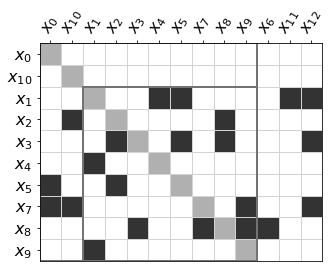

In [4]:
render_incidence(*formulation_scc, dsm=True);

# Generate polynomials 

In [5]:
rng = np.random.default_rng(12345)
polynomials, var_mapping, edges, tree, comps = generate_random_polynomials(eq_incidence, outset, n_eqs, rng)

In [6]:
polynomials

{0: -0.4*x_1*x_9 + 0.6,
 1: 0.2*x_1*x_12*x_5 - 0.6*x_11*x_4 + 0.3,
 2: 0.9*x_1*x_4 - 0.5,
 3: 0.9*x_0 + 0.3,
 4: 0.4*x_10 + 0.8*x_2*x_8 - 0.3,
 5: -0.3*x_12*x_8 - 0.7*x_2*x_3*x_5 - 0.1,
 6: -0.7*x_0*x_10 + 0.7*x_12 + 0.2*x_7*x_9 + 0.2,
 7: 0.4*x_0*x_2*x_5 + 0.7,
 8: -0.1*x_3*x_6 - 0.5*x_7*x_8*x_9 + 0.3,
 9: 0.8 - 0.3*x_10}

In [7]:
edges_dsm, tree_dsm = formulation_scc
prob_original, mdao_in_original, groups_original = run_valid_formulation(edges_dsm, tree_dsm, comps, dict(), dict(), dict(), default_nodetyperepr)

In [8]:
#initvals = [-55.082920, -9.000000, -1.460317]
for idx, invar in enumerate(mdao_in_original):
    prob_original.set_val(var_mapping[invar][1], 1.)

In [9]:
prob_original.run_model()


===
s_1
===
+  
+  =======
+  s_1.s_2
+  =======
+  NL: NewtonSolver 'NL: Newton' on system 's_1.s_2' failed to converge in 10 iterations.
+  
+  =======
+  s_1.s_2
+  =======
+  NL: NewtonSolver 'NL: Newton' on system 's_1.s_2' failed to converge in 10 iterations.
+  
+  =======
+  s_1.s_2
+  =======
+  NL: Newton Converged in 4 iterations
NL: Newton Converged in 2 iterations


In [10]:
xsol = extractvals(prob_original, [var for var,varname in var_mapping.values()])

In [11]:
print_vars_in_order(prob_original, edges_dsm, tree_dsm, var_mapping)

,0
x_12,1.000000
x_11,1.000000
x_6,1.000000
x_9,1.696112
x_8,-0.079377
x_7,-4.487388
x_5,0.434847
x_4,0.628189
x_3,-0.020731
x_2,12.073205


# Restructure

In [18]:
new_outset = {0: 11, 1: 21, 2: 14, 3: 10, 4: 18, 5: 13, 6: 22, 7: 15, 8: 16, 9: 20}
edges_r,tree_r,outset_2 = eqv_to_edges_tree(eq_incidence, new_outset, n_eqs=n_eqs)
formulation_scc_r = reformulate(edges_r, tree_r)

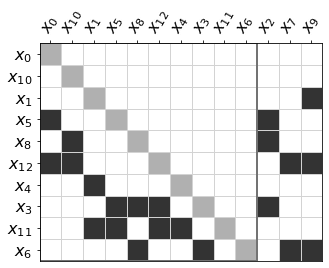

In [15]:
render_incidence(*formulation_scc_r, dsm=True);

In [16]:
ordered_edges, ordered_tree = formulation_scc_r
id_mapping = {var[0].varid: var[0] for key,var in var_mapping.items()}
newcomps = transform_components(edges, ordered_edges, comps, id_mapping)

# Run new structure

In [17]:
prob, mdao_in, groups = run_valid_formulation(ordered_edges, ordered_tree, comps+newcomps, dict(), dict(), dict(), default_nodetyperepr)

In [37]:
outvar_names = [var_mapping[val][1] for val in outset_2.values()]
x_perturbed = partial_perturb(xsol, outvar_names, rand_range=(1,1))
for key,val in x_perturbed.items():
    prob.set_val(key, val)

In [38]:
prob.run_model()


===
s_1
===
NL: Newton Converged in 0 iterations


# Comparison

In [39]:
xsol_new = extractvals(prob_original, [var for var,varname in var_mapping.values()])
pd.DataFrame([xsol, xsol_new]).T

,0,1
x_0,-0.333333,-0.333333
x_1,0.884376,0.884376
x_2,12.073205,12.073205
x_3,-0.020731,-0.020731
x_4,0.628189,0.628189
x_5,0.434847,0.434847
x_6,1.000000,1.000000
x_7,-4.487388,-4.487388
x_8,-0.079377,-0.079377
x_9,1.696112,1.696112
